# Modeling

### Import Relevant Libraries

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, snowball
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.util import ngrams
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder 
from nltk.util import ngrams

nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix, classification_report, r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\capta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read in Processed Data

In [3]:
df = pd.read_parquet('./Data/processed_reports.parquet')

In [4]:
df.reset_index(inplace=True)

In [5]:
df.drop(['index'],axis=1,inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Data columns (total 99 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player                       4209 non-null   object 
 1   report                       4209 non-null   object 
 2   year                         4209 non-null   float64
 3   weight_x                     3986 non-null   float64
 4   height_x                     3986 non-null   float64
 5   pos_rk                       3871 non-null   float64
 6   ovr_rk                       3292 non-null   float64
 7   grade                        3877 non-null   float64
 8   age                          3897 non-null   float64
 9   Round                        4209 non-null   Int64  
 10  Pick                         4209 non-null   Int64  
 11  target                       4209 non-null   Int64  
 12  processed_report             4209 non-null   object 
 13  reportlen         

In [7]:
df['target'] = df.Round

In [8]:
df.target[df.target >= 6] = 0

In [9]:
df.target[df.target == 1] = 10

In [10]:
df.target[(df.target == 4) | (df.target == 5)] = 1

In [11]:
df.target[df.target == 3] = 2

In [12]:
df.target[df.target == 10] = 3

In [13]:
cleaned_df = df.drop(['report','processed_report','joined_report','weight_y','height_y'],axis=1) 

In [14]:
cleaned_df = cleaned_df.add_suffix('_col')

In [15]:
cleaned_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,target_col,reportlen_col,forty_yd_col,vertical_col,bench_reps_col,broad_jump_col,cone_col,shuttle_col,g_season_col,def_int_season_col,def_int_yds_season_col,def_int_yds_per_int_season_col,def_int_career_col,def_int_yds_career_col,def_int_yds_per_int_career_col,pass_cmp_season_col,pass_att_season_col,pass_cmp_pct_season_col,pass_yds_season_col,pass_yds_per_att_season_col,adj_pass_yds_per_att_season_col,pass_td_season_col,pass_int_season_col,pass_rating_season_col,pass_cmp_career_col,pass_att_career_col,pass_cmp_pct_career_col,pass_yds_career_col,pass_yds_per_att_career_col,adj_pass_yds_per_att_career_col,pass_td_career_col,pass_int_career_col,pass_rating_career_col,rush_att_season_col,rush_yds_season_col,rush_yds_per_att_season_col,rush_td_season_col,rec_season_col,rec_yds_season_col,rec_yds_per_rec_season_col,scrim_att_season_col,scrim_yds_season_col,scrim_yds_per_att_season_col,scrim_td_season_col,rush_att_career_col,rush_yds_career_col,rush_yds_per_att_career_col,rush_td_career_col,rec_career_col,rec_yds_career_col,rec_yds_per_rec_career_col,rec_td_career_col,scrim_att_career_col,scrim_yds_career_col,scrim_yds_per_att_career_col,scrim_td_career_col,fumbles_rec_yds_career_col,fumbles_rec_td_career_col,rec_td_season_col,def_int_td_season_col,def_int_td_career_col,fumbles_rec_career_col,fumbles_rec_yds_season_col,fumbles_rec_td_season_col,fumbles_rec_season_col,tackles_solo_season_col,tackles_assists_season_col,tackles_total_season_col,tackles_loss_season_col,sacks_season_col,pass_defended_season_col,tackles_solo_career_col,tackles_assists_career_col,tackles_total_career_col,tackles_loss_career_col,sacks_career_col,pass_defended_career_col,fumbles_forced_season_col,fumbles_forced_career_col,college_conference_col,speed_col,shuttle_agility_col,cone_agility_col,pos_col
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,3,173,4.71,32.0,NaN,113.0,6.82,3.96,12.0,NaN,NaN,NaN,NaN,NaN,NaN,214.0,317.0,67.5,2952.0,9.3,10.8,32.0,4.0,176.5,389.0,587.0,66.3,5203.0,8.9,9.9,47.0,8.0,164.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mountain West Conference,88.187311,176.485482,136.815911,QB
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,3,106,4.43,34.0,18.0,117.0,7.10,4.08,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153.0,913.0,6.0,8.0,34.0,313.0,9.2,187.0,1226.0,6.6,9.0,513.0,2707.0,5.3,28.0,58.0,668.0,11.5,2.0,571.0,3375.0,5.9,30.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,120.996000,168.168738,130.199966,RB
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,3,76,4.45,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,61.0,10.2,NaN,97.0,1330.0,13.7,103.0,1391.0,13.5,15.0,10.0,72.0,7.2,NaN,252.0,3541.0,14.1,39.0,262.0,3613.0,13.8,39.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,107.614900,NaN,NaN,WR
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,3,111,4.62,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,326.0,1834.0,5.6,19.0,22.0,179.0,8.1,348.0,2013.0,5.8,20.0,1112.0,5540.0,5.0,64.0,69.0,621.0,9.0,3.0,1181.0,6161.0,5.2,67.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,97.457455,NaN,NaN,RB
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,3,170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [16]:
tf = TfidfVectorizer(ngram_range=(1,3),min_df=.025,max_df =.75)

In [17]:
X = tf.fit_transform(df.joined_report)

In [18]:
report_df = pd.DataFrame(X.toarray(),columns=tf.get_feature_names())

In [19]:
report_df.columns

Index(['2001', '2002', '2003', '2004', '2005', '2006', '2006 draft', '2007',
       '2014', '2015',
       ...
       'work ethic', 'worth', 'would', 'yard', 'yard averag', 'yard per',
       'yard touchdown', 'year', 'year starter', 'zone'],
      dtype='object', length=519)

In [20]:
model_df = pd.concat([cleaned_df,report_df],axis=1)

In [83]:
model_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,...,zone blocker,zone blocker good,zone buster,zone corner,zone coverag,zone heavi,zone heavi scheme,zone look,zone run,zone scheme
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,Jeff Gunter,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,252,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4205,Trenton Gill,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,255,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4206,Jesse Luketa,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,256,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4207,Marquis Hayes,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,257,...,0.0,0.0,0.0,0.0,0.0,0.142386,0.146892,0.0,0.0,0.0


In [84]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

In [73]:
y

array([  0,   1,   2, ..., 255, 256, 259])

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('lin',LinearRegression())
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
}

lin = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [86]:
lin.fit(X_train,y_train)
y_pred = lin.predict(X_test)
print(r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

0.19690862420821043 3986.479060904487


In [68]:
y_test

array([199., 151., 127., ..., 204.,  71., 199.])

In [69]:
y_pred

C:\Users\capta\AppData\Local\Temp\ipykernel_308\406269503.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(y_pred)


array([208.31706603, 136.95619738, 150.36289436, ..., 183.66545674,
                nan, 137.57179944])

(0.0, 270.0)

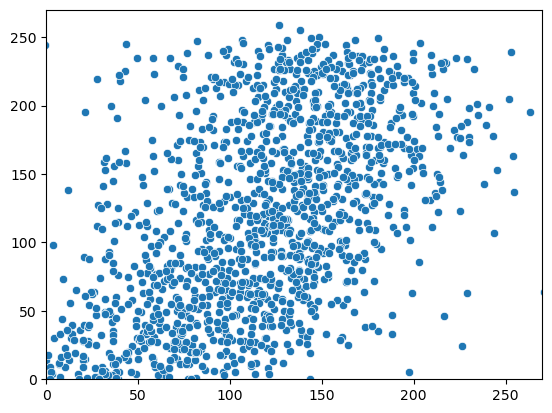

In [87]:
sns.scatterplot(y_pred,y_test)
plt.xlim(0,270)
plt.ylim(0,270)

In [125]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('forest',RandomForestRegressor())
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'forest__n_estimators':[95,100,105]
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#     'forest__max_depth':[4,12,None],
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

forest = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [124]:
forest.best_params_

{'forest__n_estimators': 100, 'sample': RandomOverSampler(random_state=42)}

In [ ]:
forest.fit(X_train,y_train)
y_pred_forest = forest.predict(X_test)
print(r2_score(y_test,y_pred_forest),mean_squared_error(y_test,y_pred_forest));

(0.0, 270.0)

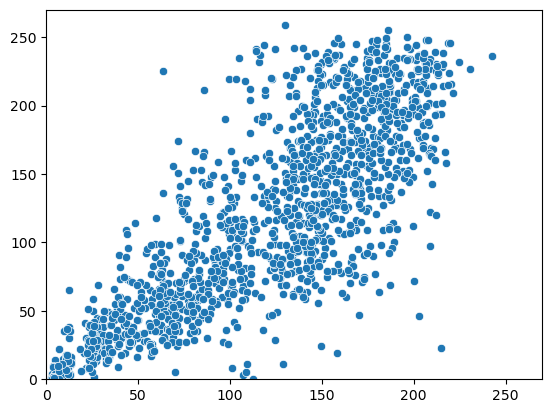

In [122]:
sns.scatterplot(y_pred_forest,y_test)
plt.xlim(0,270)
plt.ylim(0,270)

(0.0, 270.0)

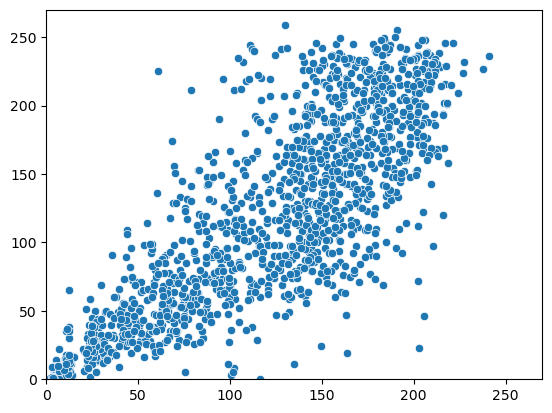

In [90]:
sns.scatterplot(y_pred_forest,y_test)
plt.xlim(0,270)
plt.ylim(0,270)

In [117]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('knn',KNeighborsRegressor())
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'knn__n_neighbors':[30,40]
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#     'forest__max_depth':[4,12,None],
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

knn = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [118]:
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)
print(r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\

0.3584595525244936 3184.5536357091432


(0.0, 270.0)

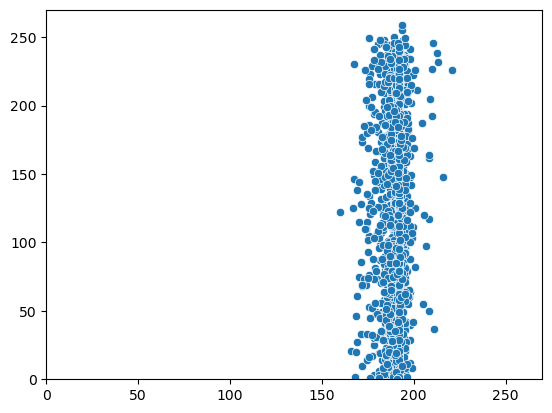

In [119]:
sns.scatterplot(y_pred_knn,y_test)
plt.xlim(0,270)
plt.ylim(0,270)

In [99]:
y_test

array([199, 151, 127, ..., 204,  71, 199])

In [100]:
y_pred

array([129.13757939, 118.27768244, 114.78338382, ..., 134.38755127,
       135.86275056, 118.93896457])

In [106]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('tree',DecisionTreeRegressor(random_state=42))
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)]
#     'forest__n_estimators':[75,100,125],
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#     'forest__max_depth':[4,12,None],
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

tree = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [107]:
tree.fit(X_train,y_train)
y_pred_tree = tree.predict(X_test)
print(r2_score(y_test,y_pred_tree),mean_squared_error(y_test,y_pred_tree));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

0.3584595525244936 3184.5536357091432


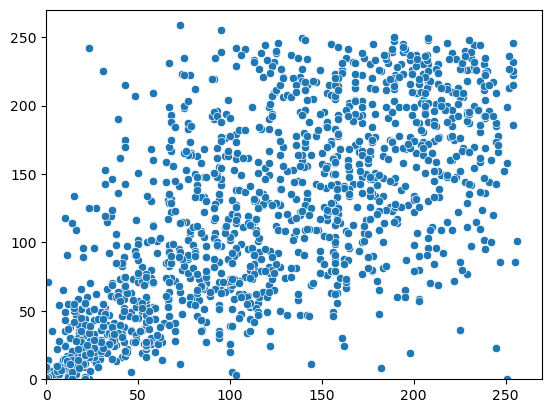

In [108]:
sns.scatterplot(y_pred_tree,y_test)
plt.xlim(0,270)
plt.ylim(0,270);

In [45]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('xgb',XGBRegressor())
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'xgb__max_depth':[3,2,1],
    'xgb__eta':[.22,.23,.24],
    'xgb__gamma':[0,1,2]
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

xgb = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [47]:
xgb.best_params_

{'sample': RandomOverSampler(random_state=42),
 'xgb__eta': 0.23,
 'xgb__gamma': 0,
 'xgb__max_depth': 2}

In [46]:
start_time = time.time()
xgb.fit(X_train,y_train)
print("--- %s seconds ---" % (time.time() - start_time))
y_pred_xgb = xgb.predict(X_test)
print(r2_score(y_test,y_pred_xgb),mean_squared_error(y_test,y_pred_xgb));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
135 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\cap

--- 192.98353838920593 seconds ---
0.6356381170292185 1808.6622031305865


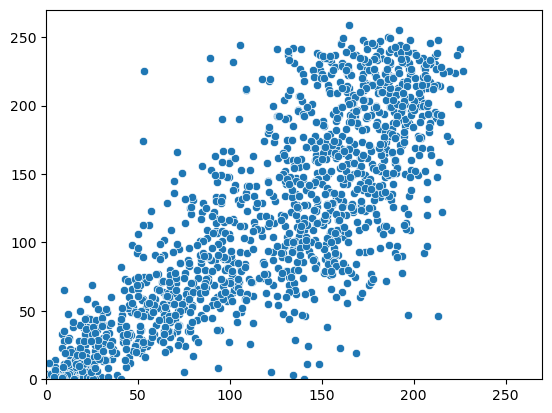

In [43]:
sns.scatterplot(y_pred_xgb,y_test)
plt.xlim(0,270)
plt.ylim(0,270);

In [66]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('ada',AdaBoostRegressor(random_state=42))
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'ada__n_estimators':[38,40],
    'ada__learning_rate':[.35,.4],
    'ada__loss':['linear','square','exponential']
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

ada = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [69]:
ada.best_params_

{'ada__learning_rate': 0.35,
 'ada__loss': 'linear',
 'ada__n_estimators': 40,
 'sample': RandomOverSampler(random_state=42)}

In [68]:
start_time = time.time()
ada.fit(X_train,y_train)
print(((time.time() - start_time)/60),'minutes')
y_pred_ada = ada.predict(X_test)
print(r2_score(y_test,y_pred_ada),mean_squared_error(y_test,y_pred_ada));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capt

6.232360887527466 seconds
0.6287644902246303 1842.7823171735827


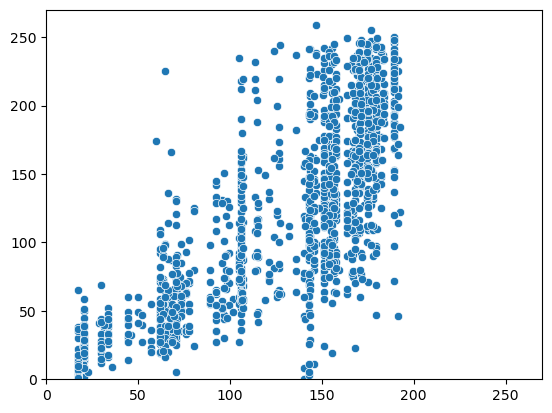

In [67]:
sns.scatterplot(y_pred_ada,y_test)
plt.xlim(0,270)
plt.ylim(0,270);

In [74]:
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('grad',GradientBoostingRegressor(random_state=42))
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'grad__n_estimators':[60,75,90],
    'grad__learning_rate':[.1,.25,.05],
    'grad__loss':['absolute_error','squared_error','huber','quantile'],
    'grad__min_samples_split':[1,2,3],
    'grad__min_samples_leaf':[1,2,3],
    'grad__max_depth':[2,3,4,None],
    'grad__min_impurity_decrease':[0,.5,1]
}

grad = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [ ]:
start_time = time.time()
grad.fit(X_train,y_train)
print(((time.time() - start_time)/60),'minutes')
y_pred_grad = grad.predict(X_test)
print(r2_score(y_test,y_pred_grad),mean_squared_error(y_test,y_pred_grad));

In [72]:
grad.best_params_

{'grad__learning_rate': 0.1,
 'grad__loss': 'squared_error',
 'grad__n_estimators': 75,
 'sample': RandomOverSampler(random_state=42)}